In [1]:
import torch
from torch.utils.data import DataLoader
from torch import optim
import torchvision
from torch.utils.tensorboard import SummaryWriter

import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from itertools import product
from copy import copy

In [2]:
torch.manual_seed(0)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda')

# Data

SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data preprocessing and formatting. 


### Overview

- 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 0.
- 73257 digits for training, 26032 digits for testing, and 531131 additional, somewhat less difficult samples, to use as extra training data

In [5]:
PATH = 'drive/My Drive/Colab Notebooks'
dataset = torchvision.datasets.SVHN(PATH,
                                    split='train',
                                    transform=torchvision.transforms.ToTensor(),
                                    target_transform=None, download=True)

Using downloaded and verified file: drive/My Drive/Colab Notebooks/train_32x32.mat


In [6]:
dataset

Dataset SVHN
    Number of datapoints: 73257
    Root location: drive/My Drive/Colab Notebooks
    Split: train
    StandardTransform
Transform: ToTensor()

In [7]:
test = torchvision.datasets.SVHN(PATH, split='test', transform=torchvision.transforms.ToTensor(), target_transform=None, download=True)

Using downloaded and verified file: drive/My Drive/Colab Notebooks/test_32x32.mat


In [8]:
test

Dataset SVHN
    Number of datapoints: 26032
    Root location: drive/My Drive/Colab Notebooks
    Split: test
    StandardTransform
Transform: ToTensor()

In [9]:
x, y = dataset[0]

In [10]:
x.size()

torch.Size([3, 32, 32])

The dataset consists of 73,257 RGB images with size 32x32

In [11]:
train_size = int(len(dataset)*0.8)
validation_size = len(dataset) - train_size

train, validation = torch.utils.data.random_split(dataset, [train_size, validation_size])

In [12]:
len(train), len(validation)

(58605, 14652)

In [13]:
train_data_loader = DataLoader(train, batch_size=64)

In [14]:
images, targets = next(iter(train_data_loader))

In [15]:
images.size()

torch.Size([64, 3, 32, 32])

In [16]:
len(torch.flatten(images[0]))

3072

In [17]:
def convert_tensor_to_array(tensor):
  
  image = np.asarray(tensor)
  # move the first axis to the end
  image = np.rollaxis(image, 0, 3)

  return image

In [18]:
def plot_batch(images, targets):
  
  rows, cols = 8, 8

  fig, axs = plt.subplots(rows, cols, figsize=(10, 12))

  for i, (fig_row, fig_col) in enumerate(product(range(rows), range(cols))):
    
    tensor = images[i]

    img = convert_tensor_to_array(tensor)

    ax = axs[fig_row, fig_col]
    ax.imshow(img)

    ax.set_title(int(targets[i]))

    ax.axis('off')

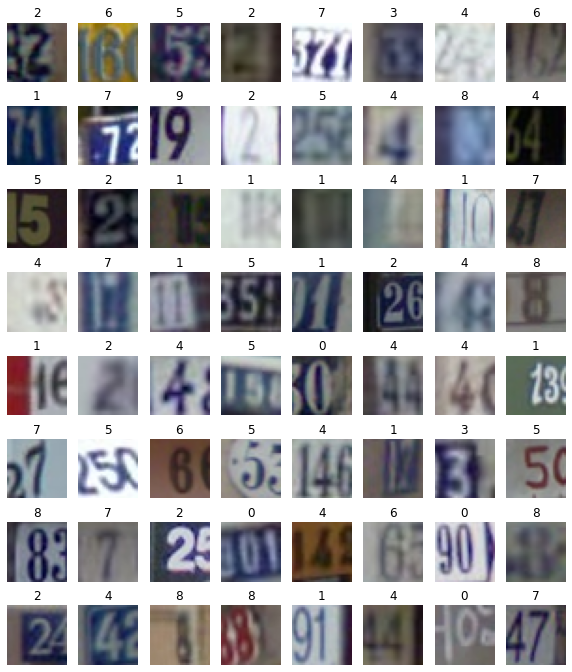

In [19]:
plot_batch(images, targets)

# First baseline

In [20]:
def get_model_baseline_fully_connected():
    
    D_in, H1, H2, D_out = 3072, 128, 64, 10

    model = torch.nn.Sequential(
      torch.nn.Flatten(),
      torch.nn.Linear(D_in, H1),
      torch.nn.ReLU(),
      torch.nn.Linear(H1, H2),
      torch.nn.ReLU(),
      torch.nn.Linear(H2, D_out),
    )
    
    model.to(device)
    
    return model, optim.Adam(model.parameters(), lr=0.001)

# Second baseline

In [21]:
def get_model_baseline_cnn():
    
    in_channels = 3 #RGB
    filters1 = 10
    filters2 = 20

    H, D_out = 64, 10

    model = torch.nn.Sequential(
      torch.nn.Conv2d(in_channels, filters1, kernel_size=3, stride=1, padding=1),
      torch.nn.ReLU(),
      torch.nn.MaxPool2d(kernel_size=2, stride=2),
      torch.nn.Conv2d(filters1, filters2, kernel_size=3, stride=1, padding=1),
      torch.nn.ReLU(),
      torch.nn.MaxPool2d(kernel_size=2, stride=2),
      torch.nn.Flatten(),
      torch.nn.Linear(8*8*filters2, H),
      torch.nn.ReLU(),
      torch.nn.Linear(H, D_out),
    )
    
    model.to(device)

    return model, optim.Adam(model.parameters(), lr=0.001)

# Evaluations

## Train and Fit helper functions

In [22]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [23]:
def loss_batch(model_output, loss_func, xb, yb, opt=None):
    
    output = loss_func(model_output, yb)

    if opt is not None:
        output.backward()
        opt.step()
        opt.zero_grad()

    return output.item(), len(xb)

In [24]:
def loss_batches(model, data_loader, loss_func, opt=None):

  correct = 0
  losses, batch_sizes = [], []
  
  for xb, yb in data_loader:
    
    xb, yb = xb.to(device), yb.to(device)
    model_output = model(xb)
    _, y_predict = torch.max(model_output.data, 1)
    correct += (y_predict == yb).sum().item()

    loss, batch_size = loss_batch(model_output, loss_func, xb, yb, opt)
    
    losses.append(loss)
    batch_sizes.append(batch_size)

  return correct, losses, batch_sizes

In [25]:
def calc_loss(losses, nums):
  
  return np.sum(np.multiply(losses, nums)) / np.sum(nums)

In [26]:
def accuracy(correct, batch_sizes):
  return correct/np.sum(batch_sizes)

In [27]:
def train_epoch(model, data_loader, loss_func, eval_func, opt):
  
  model.train()

  correct, losses, batch_sizes = loss_batches(model, data_loader, loss_func, opt)
  
  return eval_func(correct, batch_sizes), calc_loss(losses, batch_sizes)

In [28]:
def validate_epoch(model, data_loader, loss_func, eval_func, opt):
  
  model.eval()
  with torch.no_grad():
      correct, losses, batch_sizes = loss_batches(model, data_loader, loss_func)

  return eval_func(correct, batch_sizes), calc_loss(losses, batch_sizes)

In [29]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):

    train_losses, valid_losses = [], []
    train_accs, valid_accs = [], []

    for epoch in range(epochs):

      train_acc, train_loss = train_epoch(model, train_dl, loss_func, 
                                              accuracy, opt)
      train_accs.append(train_acc)
      train_losses.append(train_loss)

      valid_acc, val_loss = validate_epoch(model, valid_dl, loss_func, 
                                               accuracy, opt) 
      valid_accs.append(valid_acc)
      valid_losses.append(val_loss)

      print(epoch, f'train_loss={train_loss}\tval_loss={val_loss}')

    return train_losses, valid_losses, train_accs, valid_accs

## Visualization

For each model, we will calculate the loss and the accuracy on the train and the validation set after every epoch, and then plot these losses

In [30]:
def plot_loss(title, epochs, train_losses, val_losses):
  plt.plot(range(epochs), train_losses, label='Train')
  plt.plot(range(epochs), val_losses, label='Validation')
  plt.legend()
  plt.title(title)
  plt.xlabel('epochs')
 

In [31]:
batch_size = 64
epochs = 30
loss_fn = torch.nn.CrossEntropyLoss()

train_dl, valid_dl = get_data(train, validation, batch_size)
model1, opt = get_model_baseline_fully_connected()
train_losses1, val_losses1, train_accs1, valid_accs1 = fit(epochs, model1, loss_fn, opt, train_dl, valid_dl)

0 train_loss=2.227278270470019	val_loss=2.0992084654048595
1 train_loss=1.7986381648272523	val_loss=1.5786008072003554
2 train_loss=1.5338986935606183	val_loss=1.4865694942937795
3 train_loss=1.4427774506536282	val_loss=1.4201919199695947
4 train_loss=1.3842065698609662	val_loss=1.3526447707110338
5 train_loss=1.3348337758798747	val_loss=1.319635222786735
6 train_loss=1.3006614590553627	val_loss=1.2914970165193325
7 train_loss=1.2877448509378386	val_loss=1.3161718391050838
8 train_loss=1.2731365208190086	val_loss=1.3308779843153604
9 train_loss=1.2634202567864457	val_loss=1.284502505377411
10 train_loss=1.2540324844076063	val_loss=1.2988706723998682
11 train_loss=1.2509437511951969	val_loss=1.2763390540425776
12 train_loss=1.2449059152794357	val_loss=1.2717006560593005
13 train_loss=1.240502075544448	val_loss=1.2459856092750847
14 train_loss=1.2336202359099853	val_loss=1.2519922267534744
15 train_loss=1.2315871924164454	val_loss=1.289426552217709
16 train_loss=1.2273698723709794	val_lo

In [32]:
batch_size = 64
epochs = 30
loss_fn = torch.nn.CrossEntropyLoss()

train_dl, valid_dl = get_data(train, validation, batch_size)
model2, opt = get_model_baseline_cnn()
train_losses2, val_losses2, train_accs2, valid_accs2 = fit(epochs, model2, loss_fn, opt, train_dl, valid_dl)

0 train_loss=1.4557719119599366	val_loss=0.8019170120639161
1 train_loss=0.6643257009577257	val_loss=0.6235900711499047
2 train_loss=0.5776055335622224	val_loss=0.5918202298181551
3 train_loss=0.5319984735197484	val_loss=0.5514530335542057
4 train_loss=0.49874270762480644	val_loss=0.5425833548934546
5 train_loss=0.47346639672233715	val_loss=0.5201141112998897
6 train_loss=0.44992471208101287	val_loss=0.5157931014761195
7 train_loss=0.4308399636701109	val_loss=0.5094926086420444
8 train_loss=0.4141010615867556	val_loss=0.49052517199464224
9 train_loss=0.397320261729088	val_loss=0.49064681600294185
10 train_loss=0.38166990504361653	val_loss=0.47299913773600466
11 train_loss=0.36910276294985217	val_loss=0.5075073094762417
12 train_loss=0.3551625714154793	val_loss=0.472080846375336
13 train_loss=0.3429232570022744	val_loss=0.4875166599554603
14 train_loss=0.3349549474518674	val_loss=0.4748772030771023
15 train_loss=0.3240816454097747	val_loss=0.4873912368694876
16 train_loss=0.317824005505

### **Problem 1**

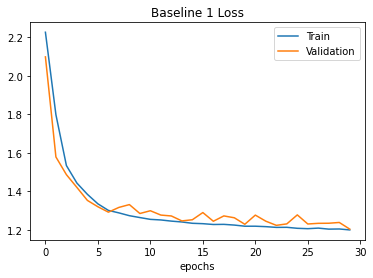

In [33]:
plot_loss('Baseline 1 Loss', epochs, train_losses1, val_losses1)

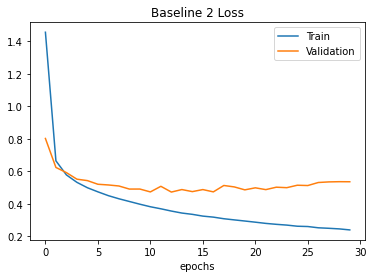

In [34]:
plot_loss('Baseline 2 Loss', epochs, train_losses2, val_losses2)

### **Problem 2**

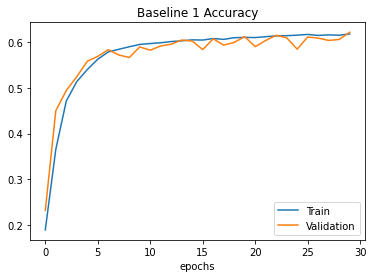

In [35]:
plot_loss('Baseline 1 Accuracy', epochs, train_accs1, valid_accs1)

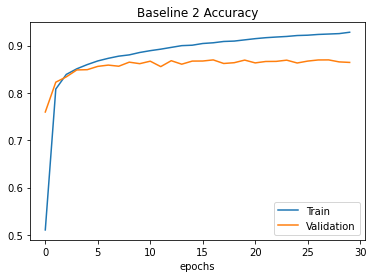

In [36]:
plot_loss('Baseline 2 Accuracy', epochs, train_accs2, valid_accs2)

We will measure the accuracy on the test dataset

In [37]:
loss_fn = torch.nn.CrossEntropyLoss()

test_data_loader = DataLoader(test, batch_size=64)
accuracy1, loss1 = validate_epoch(model1, test_data_loader, loss_fn, accuracy, opt=None)

accuracy1

0.5885832821143209

In [38]:
test_data_loader = DataLoader(test, batch_size=64)
accuracy2, loss2 = validate_epoch(model2, test_data_loader, loss_fn, accuracy,
                                opt=None)

accuracy2

0.8550245851259988

As we can see from the loss and accuracy graphs, the CNN model suffers from overfitting. Starting from about the tenth epoch, the loss increases and the accuracy decreases, while the loss and accuracy in the train set improve. In addition, the accuracy on the training set is very high (close to 1), while in the validation and test sets it is closer to 8.5. These are a clear signs of overfitting - the model is too specific to the training set.

The accuracy of the fully connected model on the train, validation and test dataset is quite similar, which shows that there is a minor overfitting or none at all.

# Designing my own NN

While the fully connected model did not overfit, its performance on the validation and the test sets was much worse than the CNN model. These is not suprising, as CNN models are more compatible to image recognition tasks.

Therefore, the improved model will also use a CNN architecture. We will try to improve its performance using data augmentation and regularization, and hopefully the model will generalize better on the test set.

In [39]:
def get_model_cnn():
    
    in_channels = 3 #RGB

    H, D_out = 64, 10

    model = torch.nn.Sequential(
      torch.nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
      torch.nn.ReLU(),
      torch.nn.MaxPool2d(kernel_size=2, stride=2),
      torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
      torch.nn.ReLU(),
      torch.nn.MaxPool2d(kernel_size=2, stride=2),
      torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
      torch.nn.ReLU(),
      torch.nn.MaxPool2d(kernel_size=2, stride=2),
      torch.nn.Flatten(),
      torch.nn.Linear(4*4*128, H),
      torch.nn.ReLU(),
      torch.nn.Linear(H, D_out),
    )
     
    model.to(device)
    
    return model, optim.Adam(model.parameters(), lr=0.001)

In [40]:
batch_size = 64
epochs = 10
loss_fn = torch.nn.CrossEntropyLoss()

train_dl, valid_dl = get_data(train, validation, batch_size)
model_cnn, opt = get_model_cnn()
train_losses3, val_losses3, train_accs3, valid_accs3 = fit(epochs, model_cnn, loss_fn, opt, train_dl, valid_dl)

0 train_loss=1.349724122906553	val_loss=0.6509538040830241
1 train_loss=0.5447171037519113	val_loss=0.5099276384954533
2 train_loss=0.4381801398711119	val_loss=0.45935640545318335
3 train_loss=0.3886930502439438	val_loss=0.40929676721306274
4 train_loss=0.3504505574143835	val_loss=0.38978066631200503
5 train_loss=0.32228194714436686	val_loss=0.3856951292993721
6 train_loss=0.297747369021846	val_loss=0.40081864903769204
7 train_loss=0.2767470114442251	val_loss=0.3927475146312646
8 train_loss=0.26076239060240897	val_loss=0.3735167077418855
9 train_loss=0.2450587029463093	val_loss=0.3710161976693206


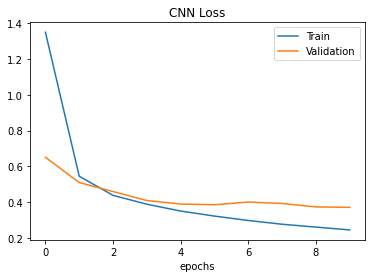

In [41]:
plot_loss('CNN Loss', epochs, train_losses3, val_losses3)

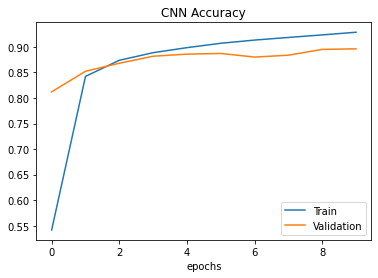

In [42]:
plot_loss('CNN Accuracy', epochs, train_accs3, valid_accs3)

Validation accuracy

In [43]:
valid_accs3[-1]

0.8961916461916462

Test accuracy

In [44]:
test_data_loader = DataLoader(test, batch_size=64)
accuracy_test, loss_test = validate_epoch(model_cnn, test_data_loader, loss_fn, 
                                          accuracy, opt=None)

accuracy_test

0.8872157344806392

As we can see, this model is better than the baseline models, but there is still room for improvement. This model performs better on the train, so there might be some overfitting. We will try to generalize the model better.

In [45]:
model_cnn_name = 'model_cnn'
torch.save(model_cnn.state_dict(), f'{PATH}/{model_cnn_name}')

**Improving the model**

We will apply some measures to avoid overfitting and increase generalization.

In [46]:
def get_model_cnn_improved():
    
    in_channels = 3 #RGB

    H, D_out = 64, 10

    model = torch.nn.Sequential(
      torch.nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
      torch.nn.ReLU(),
      torch.nn.MaxPool2d(kernel_size=2, stride=2),
      torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
      torch.nn.ReLU(),
      torch.nn.BatchNorm2d(64),
      torch.nn.MaxPool2d(kernel_size=2, stride=2),
      torch.nn.Dropout(p=0.2),
      torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
      torch.nn.ReLU(),
      torch.nn.BatchNorm2d(128),
      torch.nn.MaxPool2d(kernel_size=2, stride=2),
      torch.nn.Dropout(p=0.2),
      torch.nn.Flatten(),
      torch.nn.Linear(4*4*128, H),
      torch.nn.ReLU(),
      torch.nn.Linear(H, D_out),
    )

    model.to(device)
     
    return model, optim.Adam(model.parameters(), lr=0.001)

In [47]:
batch_size = 64
epochs = 10
loss_fn = torch.nn.CrossEntropyLoss()

train_dl, valid_dl = get_data(train, validation, batch_size)
model_cnn_improved, opt = get_model_cnn_improved()
train_losses4, val_losses4, train_accs4, valid_accs4 = fit(epochs, model_cnn_improved, loss_fn, opt, train_dl, valid_dl)

0 train_loss=0.777003427161443	val_loss=0.4380413240059262
1 train_loss=0.4246084820485829	val_loss=0.3595438684770848
2 train_loss=0.3575514380801264	val_loss=0.35410679126254463
3 train_loss=0.31322857727726594	val_loss=0.32818430265116294
4 train_loss=0.28422202525534696	val_loss=0.3086192861968235
5 train_loss=0.26306306010229924	val_loss=0.29895198390746164
6 train_loss=0.242694771636642	val_loss=0.301115778969703
7 train_loss=0.2234066808514094	val_loss=0.30984266920393033
8 train_loss=0.21007546455242682	val_loss=0.298445845590795
9 train_loss=0.19638904502200405	val_loss=0.29459304659704416


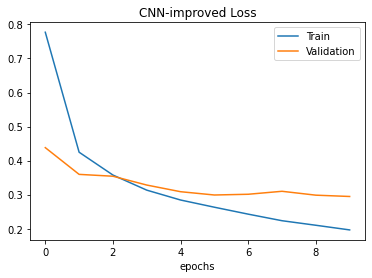

In [48]:
plot_loss('CNN-improved Loss', epochs, train_losses4, val_losses4)

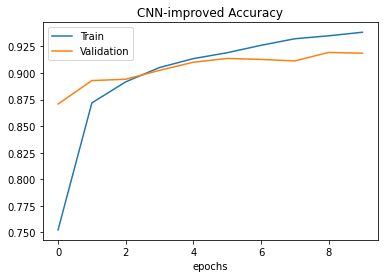

In [49]:
plot_loss('CNN-improved Accuracy', epochs, train_accs4, valid_accs4)

In [50]:
valid_accs4[-1]

0.9186459186459186

In [51]:
test_data_loader = DataLoader(test, batch_size=64)
accuracy_test, loss_test = validate_epoch(model_cnn_improved, test_data_loader, loss_fn, 
                                          accuracy, opt=None)

accuracy_test

0.916180086047941

As we can see, Batch Normalization and Dropout improved the performance of the model.

**Data Augmentation**

Now we will try to perform some data transformations so that our model could generalize better on an unseen dataset. We will apply random rotations and random changes to the colors of the images.

These changes will artificially make our training dataset larger, therefore we can use a larger number of epochs without the fear of overfitting. 

In [52]:
train_transformed = copy(train)
train_transformed.dataset = copy(dataset)
 
train_transformed.dataset.transform = torchvision.transforms.Compose([
    torchvision.transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
    torchvision.transforms.RandomAffine(degrees=30),
    torchvision.transforms.ToTensor(),
    ])

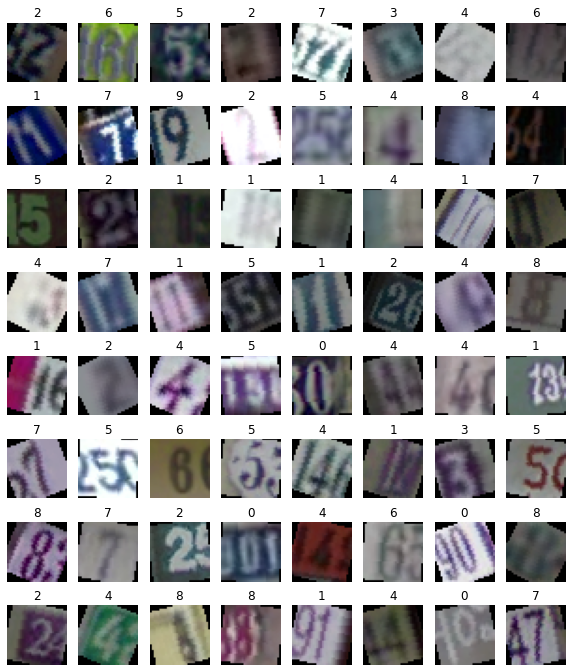

In [53]:
transformed_train_dl = DataLoader(train_transformed, batch_size=64)

images_transformed, targets = next(iter(transformed_train_dl))

plot_batch(images_transformed, targets)

In [54]:
batch_size = 64
epochs = 20
loss_fn = torch.nn.CrossEntropyLoss()

train_dl, valid_dl = get_data(train_transformed, validation, batch_size)
model_cnn_improved2, opt = get_model_cnn_improved()

train_losses5, val_losses5, train_accs5, valid_accs5 = fit(epochs, model_cnn_improved2, loss_fn, opt, train_dl, valid_dl)

0 train_loss=1.1088461729723706	val_loss=0.5542100727997482
1 train_loss=0.6209386190399051	val_loss=0.45770640265671503
2 train_loss=0.5346587284241263	val_loss=0.37935570267227675
3 train_loss=0.4940999659862588	val_loss=0.3728852118343855
4 train_loss=0.4633412991461214	val_loss=0.35350551167993705
5 train_loss=0.44067120154241013	val_loss=0.35087565337736165
6 train_loss=0.42105644268953357	val_loss=0.32954453301664066
7 train_loss=0.4097342291226943	val_loss=0.31762294206435715
8 train_loss=0.3937275217779768	val_loss=0.32701610427816613
9 train_loss=0.3820669950107372	val_loss=0.31698213518072665
10 train_loss=0.36901607842344075	val_loss=0.31256711791357705
11 train_loss=0.3583948234467872	val_loss=0.30054058959143687
12 train_loss=0.3540394632869303	val_loss=0.2961253096765747
13 train_loss=0.3509889565569052	val_loss=0.30072842336582933
14 train_loss=0.3443002118469149	val_loss=0.3027610459062137
15 train_loss=0.3357208403755288	val_loss=0.280131085901647
16 train_loss=0.32915

In [55]:
valid_accs5[-1]

0.9234234234234234

In [56]:
test_data_loader = DataLoader(test, batch_size=64)
accuracy_test, loss_test = validate_epoch(model_cnn_improved2, test_data_loader, loss_fn, 
                                          accuracy, opt=None)

accuracy_test

0.9225568531038721

### **Problem 4**

Why did I choose the follwoing options?

Dropout - it is a simple way to perform regularization. During training, some layer outputs are randomly ignored ("dropped out"). In our model, each output has the probability of 0.2 to be "dropped". Dropout makes the training process more noisy and reduces the dependency between layers, making the model more robust.

Batch Normalization - during training, the inputs of each layer are normalized by using the mean and standard deviation of the values in the batch. Batch normalization reduces the covariate shift - the change in the distribution of the covariates (predictors or input variables). This will help the model perform better on a new dataset that may have different distributions. Batch normalization also introduces some noise to each layer, providing a regularization effect.

Data Augmentation (random rotation and random color jitter) - we want the model to recognize digits, where the digits can have different background colors and different angles. Therefore, by introducing such noise, we expect the model to learn important features of digits, rather than some background noise, and therefore perform better on the test. In addition, these random transformations increase the size of the training dataset and provide more samples that the model can learn from.


### **Problem 5** 

As you can see, after adding Dropout and Batch Normalization, the accuracy on the test set increased from 0.88 to 0.91.

After applying the data transformations, the accuracy on the test set increased to 0.92. 

As I explained in Problem 4, the Dropout provides regularization, Batch Normalization makes the distribution of inputs to each layer more similar making the network more robust to changes in the input samples. Data Augmentation introduces noise that helps the model learn better features that are relevant to the classification of digits. All these additions reduce overfitting and improve generalization.

### **Problem 6**

The baselines models produced the following accuracies on the test set: 0.58 and 0.85. The improved model had a 0.92 accuracy on the test set.
This was achieved due to improving the CNN network to a deeper one with more filters that detect more features, using less epochs to avoid overfitting, and using regularization methods and adding noise that reduced overfitting and improved the generalization on the test set.

In [57]:
batch_size = 64
epochs = 10
loss_fn = torch.nn.CrossEntropyLoss()

train_dl, valid_dl = get_data(train_transformed, validation, batch_size)
model_cnn_improved_lr1, __ = get_model_cnn_improved()
opt = optim.Adam(model_cnn_improved_lr1.parameters(), lr=0.01)

train_losses6, val_losses6, train_accs6, valid_accs6 = fit(epochs, model_cnn_improved_lr1, loss_fn, opt, train_dl, valid_dl)

0 train_loss=2.2101745906599084	val_loss=1.9260867264242794
1 train_loss=1.6328981225741377	val_loss=0.8364071261352312
2 train_loss=0.9136189401388758	val_loss=0.6535905307022041
3 train_loss=0.7519430701810542	val_loss=0.5419187434638032
4 train_loss=0.6789409301639183	val_loss=0.5173964412720712
5 train_loss=0.6514040220873052	val_loss=0.48416408083655615
6 train_loss=0.6265252822129538	val_loss=0.44020066652146966
7 train_loss=0.606424099102676	val_loss=0.4398095843295989
8 train_loss=0.6011864526922126	val_loss=0.47751490655831874
9 train_loss=0.5833618956960394	val_loss=0.4522243337393002


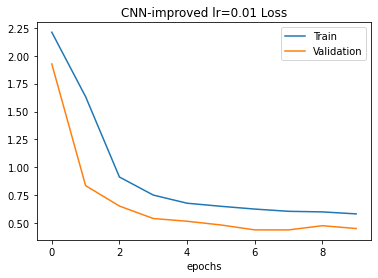

In [58]:
plot_loss('CNN-improved lr=0.01 Loss', epochs, train_losses6, val_losses6)

In [59]:
batch_size = 64
epochs = 10
loss_fn = torch.nn.CrossEntropyLoss()

train_dl, valid_dl = get_data(train_transformed, validation, batch_size)
model_cnn_improved_lr2, __ = get_model_cnn_improved()
opt = optim.Adam(model_cnn_improved_lr2.parameters(), lr=0.0001)

train_losses7, val_losses7, train_accs7, valid_accs7 = fit(epochs, model_cnn_improved_lr2, loss_fn, opt, train_dl, valid_dl)

0 train_loss=1.6819903017666833	val_loss=0.8048611335861139
1 train_loss=0.923153878505213	val_loss=0.62514136576633
2 train_loss=0.7665463887458266	val_loss=0.5731019402116562
3 train_loss=0.6881387654460236	val_loss=0.48411045656515345
4 train_loss=0.6308201616529047	val_loss=0.4976274689103683
5 train_loss=0.5822378830264507	val_loss=0.4424823760384261
6 train_loss=0.5517795882720546	val_loss=0.4092108085609153
7 train_loss=0.5275545091619265	val_loss=0.4019191115891188
8 train_loss=0.5002755714351738	val_loss=0.3900277675939264
9 train_loss=0.4821282825421355	val_loss=0.3787381377436247


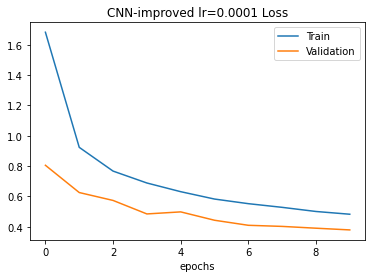

In [60]:
plot_loss('CNN-improved lr=0.0001 Loss', epochs, train_losses7, val_losses7)

### **Problem 7**

I tried a high learning rate (0.01) and a low learning rate (0.0001).
The high learning rate converged near a pretty high loss (around 2.2), which means that the model could not reach the minimum with such large steps.
The low learning rate continued to improve, but is still not close to the loss of the original learning rate (0.001) after 10 epochs. This means that the model learns slowly and will need more epochs to obtain similar results as the original model. 


# General Note
In this exercise I tested different models on the test set (holdout set). This was done for the sake of this exercise.

In the real world, we should experiments different models on the validation set, pick the best model and test it on the holdout set only once. We should recosinder the chosen model only if some problem is detected - i.e., the results are really bad on the hold out set.